# Prediction - European Calls

In [1]:
%run ../nn_option_pricer/_key_imports.py
import sys

sys.path.append("../")
from nn_option_pricer.bs import gbm_step, bs_eval_wrapper
from nn_option_pricer.nn_archi import make_model, homogeneity_network
from nn_option_pricer.utils import visualise_surface, diagnosis_hedge, diagnosis_grads

In [2]:
feat_names = ["log-strike", "ttm", "alpha", "rho", "vol-of-vol"]
f_to_i = lambda x: feat_names.index(x)

X_df = pd.read_csv("datasets/rough_bergomi_train.csv")
Xs_train = X_df[feat_names].values
ys_train = X_df["MC_call"]
true_grads_train = X_df["MC_call_delta"]

X_df_test = pd.read_csv("datasets/rough_bergomi_test.csv")
Xs_test = X_df[feat_names].values
ys_test = X_df_test["MC_call"]

print("BASELINE MSE: ", np.mean((ys_test - ys_test.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys_test - ys_test.mean())))
print(X_df.shape)

all_res = []

BASELINE MSE:  0.018205537671447
BASELINE MAE:  0.11933127648950452
(96100, 9)


In [8]:
"""
Neural Network Hyperparameters
"""


HIDDEN_UNITS = 64
LAYERS = 2
dropout_ratio = 0.0
HIDDEN_ACT = "softplus"
N_FEATS = len(feat_names)
OUTPUT_ACT = None
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 30
BATCH_NORM = False
N_FEATS = len(feat_names)

loss_fn = tf.keras.losses.MeanSquaredError()
METRICS = [
    tf.keras.metrics.MeanAbsoluteError(name="MAE"),
    tf.keras.metrics.RootMeanSquaredError(name="RMSE"),
]
VAL_SPLIT = 0.2

In [9]:
moneyness = np.exp(Xs_test[:, f_to_i("log-strike")])
ttm = np.exp(Xs_test[:, f_to_i("ttm")])
true = X_df_test["MC_call"]
intrinsic_val = np.maximum(moneyness - 1.0, 0)
all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

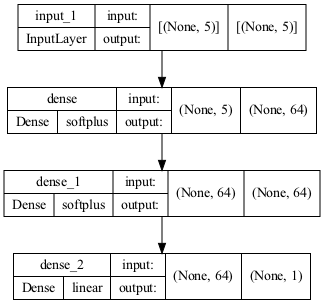

In [10]:
"""
Define Neural Network
"""
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    TQDMProgressBar(show_epoch_progress=False),
    ReduceLROnPlateau(patience=5),
]
opt = Adam(learning_rate=LR)
METHOD = "standard_ffn"

all_models[METHOD] = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)
all_models[METHOD].compile(optimizer=opt, loss=loss_fn, metrics=METRICS)
tf.keras.utils.plot_model(
    all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
)

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

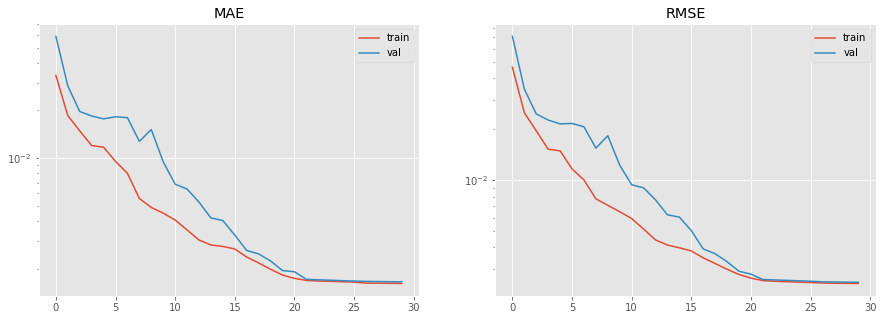

In [11]:
"""
Training
"""
start = time.time()
history = all_models[METHOD].fit(
    Xs_train,
    ys_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    shuffle=False,
    verbose=0,
    callbacks=CALLBACKS,
)
train_time = time.time() - start

metrics = ["MAE", "RMSE"]
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_yscale("log")
    ax[i].set_title(f"Error:{metric} vs no. epochs")
    ax[i].set_ylabel(f"{metric} (log-scale)")
    ax[i].set_xlabel(f"Epochs")

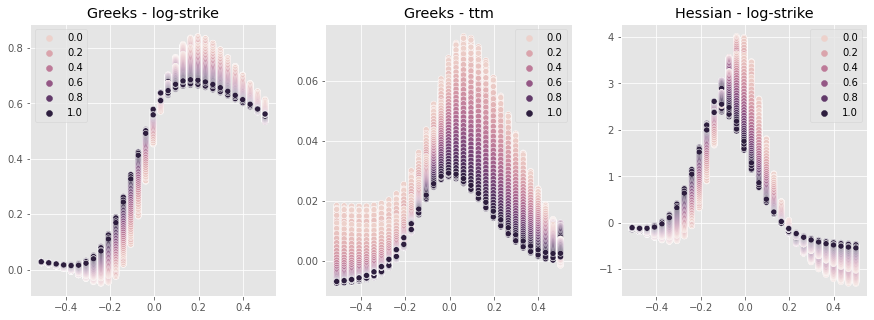

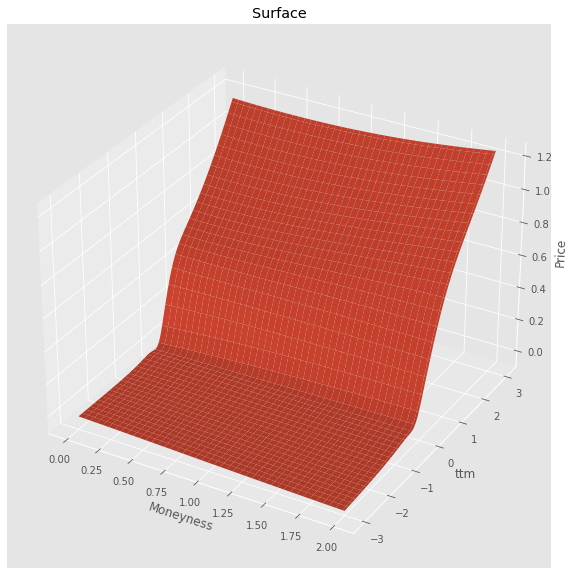

In [12]:
"""
Prediction Errors
"""
start2 = time.time()
model = all_models[METHOD]
preds = model.predict(Xs_test, batch_size=10 ** 4).reshape(-1)
X_tensor = tf.Variable(Xs_test)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log-strike")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()

temp = pd.concat(
    [
        diagnosis_pred(true, preds, lower_bound=intrinsic_val, method=METHOD),
        diagnosis_grads(
            hessian_moneyness, grads, f_to_i, "ttm", "log-strike", method=METHOD
        ),
    ],
    axis=1,
)
inference_time = time.time() - start


"""
Pricing Error
"""
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)
sns.scatterplot(
    Xs_test[:, f_to_i("log-strike")],
    true - preds,
    hue=Xs_test[:, f_to_i("ttm")],
    ax=ax[1],
)
sns.scatterplot(
    Xs_test[:, f_to_i("log-strike")], preds, hue=Xs_test[:, f_to_i("ttm")], ax=ax[0]
)

ax[0].set_xlabel("log-moneyness")
ax[1].set_xlabel("log-moneyness")
ax[0].set_ylabel("Predicted Price")
ax[1].set_ylabel("Pricing Error vs MC Price")
ax[0].set_title("Predicted Price against Moneyness\nColor: time-to-maturity)")
ax[1].set_title("Pricing Error against Moneyness\nColor: time-to-maturity)")


fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, x in enumerate(["log-strike", "ttm"]):
    sns.scatterplot(
        Xs_train[:, f_to_i("log-strike")],
        grads[:, f_to_i(x)],
        hue=Xs_train[:, f_to_i("ttm")],
        ax=ax[i],
    )
    ax[i].set_title(f"Greeks - {x}")

sns.scatterplot(
    Xs_train[:, f_to_i("log-strike")],
    hessian_moneyness[:, f_to_i("log-strike")],
    ax=ax[2],
    hue=Xs_train[:, f_to_i("ttm")],
)
ax[2].set_title(f"Hessian - log-strike")

temp["model_parameters"] = all_models[METHOD].count_params()
temp["train_time"] = train_time
temp["inference_time"] = inference_time

all_res += [temp.copy()]

"""
Visualise call surface
"""
N_POINTS = 128
SK = np.linspace(-3.0, 3, N_POINTS)
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS ** 2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
sample_params = X_df.sample(1).iloc[0].to_dict()
for x in [i for i in feat_names if i not in ["ttm", "log-strike"]]:
    X[:, f_to_i(x)] = sample_params[x] * np.ones(X.shape[0])

temp = visualise_surface(ts, SK, model(X).numpy())

# NN with a homogeneity hint

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

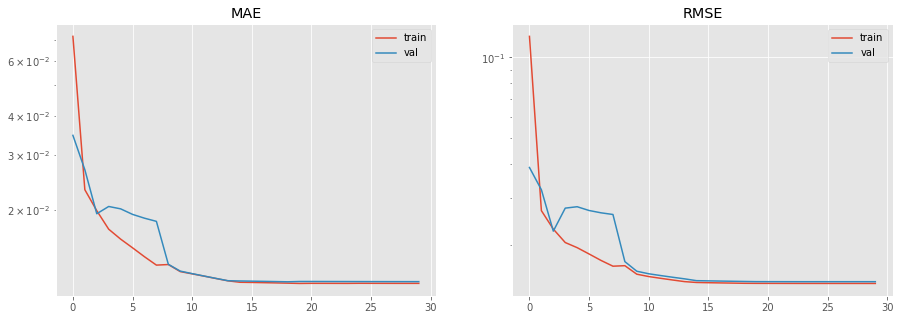

In [29]:
"""
Define Neural network
"""
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    TQDMProgressBar(show_epoch_progress=False),
    ReduceLROnPlateau(patience=5),
]
opt = Adam(learning_rate=LR)

METHOD = "gated"
all_models[METHOD] = homogeneity_network(N_FEATS, HIDDEN_UNITS, seed=42)
all_models[METHOD].compile(optimizer=opt, loss=loss_fn, metrics=METRICS)
tf.keras.utils.plot_model(
    all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
)


start = time.time()
history = all_models[METHOD].fit(
    [Xs_train[:, 0], Xs_train[:, 1], Xs_train[:, 2:]],
    ys_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    verbose=0,
    shuffle=False,
    callbacks=CALLBACKS,
)
train_time = time.time() - start
metrics = ["MAE", "RMSE"]
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_yscale("log")
    ax[i].set_title(metric)

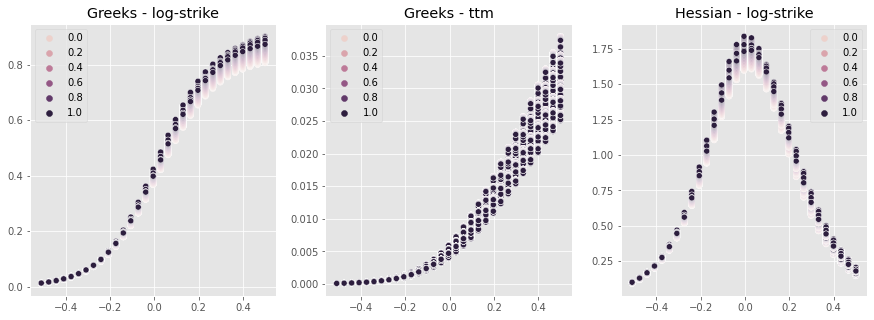

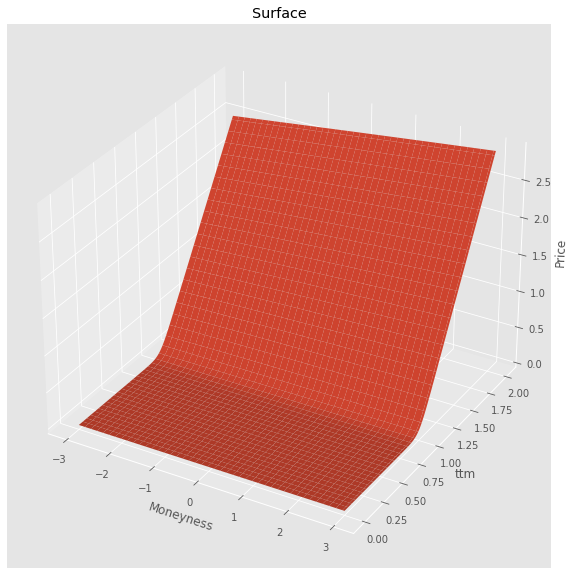

In [30]:
start2 = time.time()
model = all_models[METHOD]
preds = (
    model.predict(
        [Xs_test[:, 0], Xs_test[:, 1], Xs_test[:, 2:]], batch_size=10 ** 4
    ).reshape(-1)
).reshape(-1)

X_tensor = tf.Variable(Xs_test)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model([X_tensor[:, 0], X_tensor[:, 1], X_tensor[:, 2:]])
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log-strike")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()

temp = pd.concat(
    [
        diagnosis_pred(true, preds, lower_bound=intrinsic_val, method=METHOD),
        diagnosis_grads(
            hessian_moneyness, grads, f_to_i, "ttm", "log-strike", method=METHOD
        ),
    ],
    axis=1,
)

inference_time = time.time() - start

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, x in enumerate(["log-strike", "ttm"]):
    sns.scatterplot(
        Xs_train[:, f_to_i("log-strike")],
        grads[:, f_to_i(x)],
        hue=Xs_train[:, f_to_i("ttm")],
        ax=ax[i],
    )
    ax[i].set_title(f"Greeks - {x}")

sns.scatterplot(
    Xs_train[:, f_to_i("log-strike")],
    hessian_moneyness[:, f_to_i("log-strike")],
    ax=ax[2],
    hue=Xs_train[:, f_to_i("ttm")],
)
ax[2].set_title(f"Hessian - log-strike")

temp["model_parameters"] = all_models[METHOD].count_params()
temp["train_time"] = train_time
temp["inference_time"] = inference_time

all_res += [temp.copy()]


"""
Visualise call surface
"""
N_POINTS = 128
SK = np.linspace(-3.0, 3, N_POINTS)
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS ** 2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
sample_params = X_df.sample(1).iloc[0].to_dict()
for x in [i for i in feat_names if i not in ["ttm", "log-strike"]]:
    X[:, f_to_i(x)] = sample_params[x] * np.ones(X.shape[0])

temp = visualise_surface(SK, ts, model([X[:, 0], X[:, 1], X[:, 2:]]).numpy())

# Polynomial Basis

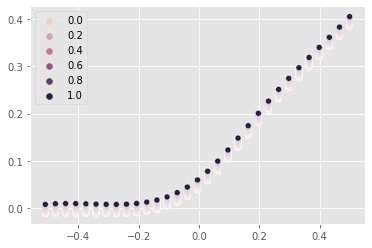

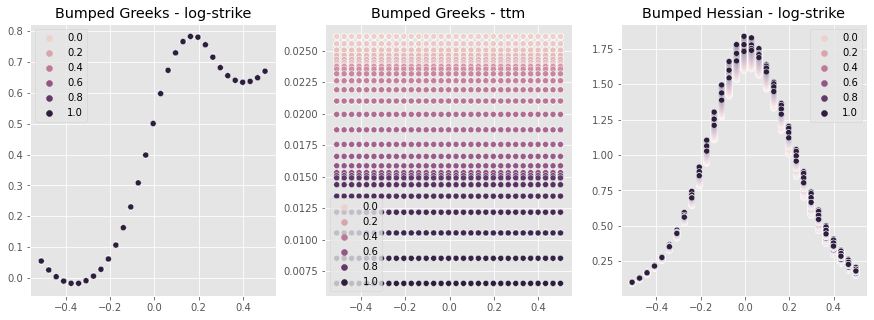

In [31]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression

start = time.time()
spline = SplineTransformer(n_knots=5, degree=3, knots="uniform", extrapolation="linear")
X2 = spline.fit_transform(Xs_train)
reg = LinearRegression(fit_intercept=False).fit(X2, X_df["MC_call"])
train_time = time.time() - start


start2 = time.time()
preds = reg.predict(spline.transform(Xs_test))
Xs_bumped = Xs_train.copy()
eps = 1e-4
# strike
bumped_greeks = np.zeros((Xs_train.shape[0], Xs_train.shape[1]))
bumped_hessian = np.zeros((Xs_train.shape[0], Xs_train.shape[1]))

Xs_bumped[:, f_to_i("log-strike")] += eps
X2_bumped = spline.transform(Xs_bumped)
preds2 = reg.predict(X2_bumped)
bumped_greeks[:, f_to_i("log-strike")] = (preds2 - preds) / eps

Xs_bumped2 = Xs_train.copy()
Xs_bumped2[:, f_to_i("log-strike")] -= eps
X2_bumped2 = spline.transform(Xs_bumped2)
preds3 = reg.predict(X2_bumped2)
bumped_hessian[:, f_to_i("log-strike")] = (preds2 - 2 * preds + preds3) / (eps * eps)

eps = 1e-2
Xs_bumped3 = Xs_train.copy()
Xs_bumped3[:, f_to_i("ttm")] += eps
X2_bumped3 = spline.transform(Xs_bumped3)
preds4 = reg.predict(X2_bumped3)
bumped_greeks[:, f_to_i("ttm")] = (preds4 - preds) / (eps)


inference_time = time.time() - start2
sns.scatterplot(
    x=Xs_test[:, f_to_i("log-strike")], y=preds, hue=Xs_test[:, f_to_i("ttm")]
)


temp = pd.concat(
    [
        diagnosis_pred(true, preds, lower_bound=intrinsic_val, method="polynomial"),
        diagnosis_grads(
            bumped_hessian,
            bumped_greeks,
            f_to_i,
            "ttm",
            "log-strike",
            method="polynomial",
        ),
    ],
    axis=1,
)

temp["model_parameters"] = len(reg.coef_) + 1
temp["train_time"] = train_time
temp["inference_time"] = inference_time

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, x in enumerate(["log-strike", "ttm"]):
    sns.scatterplot(
        Xs_test[:, f_to_i("log-strike")],
        bumped_greeks[:, f_to_i(x)],
        hue=Xs_test[:, f_to_i("ttm")],
        ax=ax[i],
    )
    ax[i].set_title(f"Bumped Greeks - {x}")

sns.scatterplot(
    Xs_test[:, f_to_i("log-strike")],
    hessian_moneyness[:, f_to_i("log-strike")],
    ax=ax[2],
    hue=Xs_test[:, f_to_i("ttm")],
)
ax[2].set_title(f"Bumped Hessian - log-strike")

all_res += [temp]

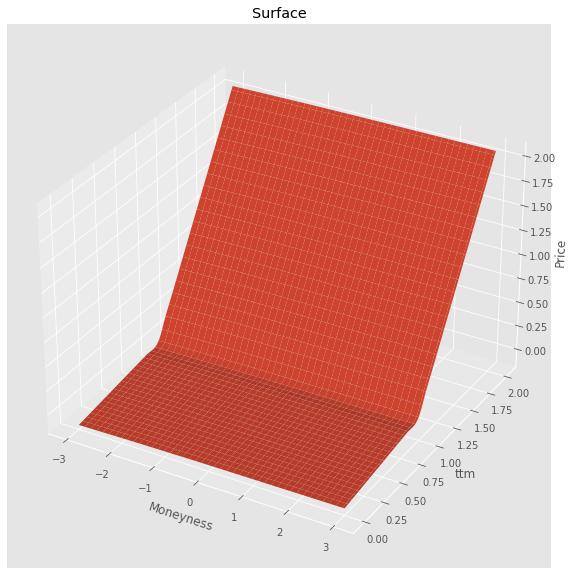

In [32]:
"""
Visualise call surface
"""
N_POINTS = 128
SK = np.linspace(-3.0, 3, N_POINTS)
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS ** 2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
sample_params = X_df.sample(1).iloc[0].to_dict()
for x in [i for i in feat_names if i not in ["ttm", "log-strike"]]:
    X[:, f_to_i(x)] = sample_params[x] * np.ones(X.shape[0])

temp = visualise_surface(SK, ts, reg.predict(spline.transform(X)))

In [245]:
loss_tracker = tf.keras.metrics.Mean(name="loss")
mae_metric = tf.keras.metrics.MeanAbsoluteError(name="mae")


class DifferentialModel(tf.keras.Model):
    @tf.function
    def train_step(self, data):
        x_var, (y, true_grad) = data
        # https://keras.io/guides/customizing_what_happens_in_fit/#going-lowerlevel
        with tf.GradientTape() as model_tape:
            with tf.GradientTape() as grad_tape:
                grad_tape.watch(x_var)
                model_pred = self(x_var, training=True)
            gradients = grad_tape.gradient(model_pred, x_var)
            grad_loss = self.compiled_loss(true_grad, gradients[:, 0])
            pred_loss = self.compiled_loss(y, model_pred)
            loss = grad_loss + pred_loss
        trainable_vars = self.trainable_variables
        model_grad = model_tape.gradient(loss, trainable_vars)
        opt.apply_gradients(zip(model_grad, trainable_vars))
        self.compiled_metrics.update_state(y, model_pred)
        return {
            m.name: m.result() for m in self.metrics
        }  # {m.name: m.result() for m in self.metrics}#loss, pred_loss, grad_loss

In [246]:
model = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)
model = DifferentialModel(model.input, model.outputs)
model.compile(optimizer=opt, loss=loss_fn, metrics=METRICS)

In [250]:
model.fit(
    Xs_train,
    (ys_train, true_grads_train),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    shuffle=False,
    verbose=0,
    callbacks=CALLBACKS,
)

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

In [ ]:
"""
Prediction Errors
"""
start2 = time.time()
preds = model.predict(Xs_test, batch_size=10 ** 5).reshape(-1)
X_tensor = tf.Variable(Xs_test)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log-strike")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()

temp = pd.concat(
    [
        diagnosis_pred(true, preds, lower_bound=intrinsic_val, method=METHOD),
        diagnosis_grads(
            hessian_moneyness, grads, f_to_i, "ttm", "log-strike", method=METHOD
        ),
    ],
    axis=1,
)
inference_time = time.time() - start

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, x in enumerate(["log-strike", "ttm"]):
    sns.scatterplot(
        Xs_train[:, f_to_i("log-strike")],
        grads[:, f_to_i(x)],
        hue=Xs_train[:, f_to_i("ttm")],
        ax=ax[i],
    )
    ax[i].set_title(f"Greeks - {x}")

sns.scatterplot(
    Xs_train[:, f_to_i("log-strike")],
    hessian_moneyness[:, f_to_i("log-strike")],
    ax=ax[2],
    hue=Xs_train[:, f_to_i("ttm")],
)
ax[2].set_title(f"Hessian - log-strike")

temp["model_parameters"] = all_models[METHOD].count_params()
temp["train_time"] = train_time
temp["inference_time"] = inference_time

all_res += [temp.copy()]

"""
Visualise call surface
"""
N_POINTS = 128
SK = np.linspace(-3.0, 3, N_POINTS)
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS ** 2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
sample_params = X_df.sample(1).iloc[0].to_dict()
for x in [i for i in feat_names if i not in ["ttm", "log-strike"]]:
    X[:, f_to_i(x)] = sample_params[x] * np.ones(X.shape[0])

temp = visualise_surface(ts, SK, model(X).numpy())

In [251]:
preds = model.predict(Xs_train, batch_size=10 ** 5).reshape(-1)

<AxesSubplot:>

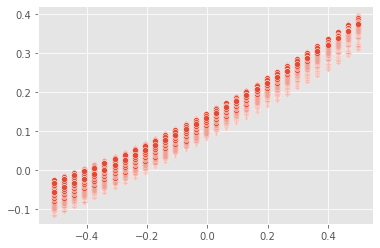

In [252]:
sns.scatterplot(Xs_train[:, f_to_i("log-strike")], preds)

  0%|          | 0/30 [00:00<?, ?it/s]

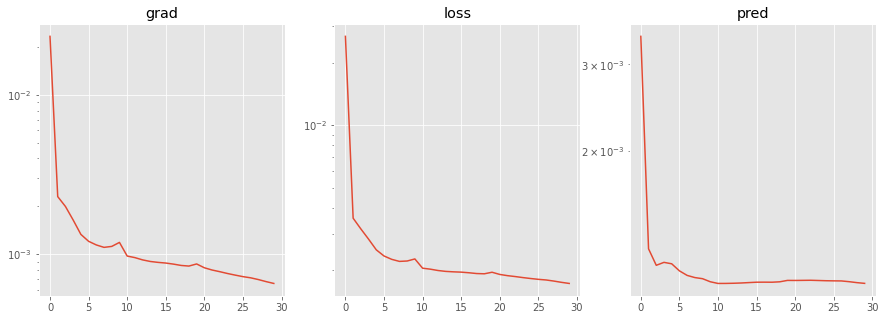

In [33]:
"""
Define Neural Network
"""
dataset = tf.data.Dataset.from_tensor_slices((Xs_train, ys_train, true_grads_train))
opt = Adam(learning_rate=LR)
model = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)

batched_dataset = dataset.batch(BATCH_SIZE)
METHOD = "differential"


@tf.function
def train(y, true_grad, x_var):
    with tf.GradientTape() as model_tape:
        with tf.GradientTape() as grad_tape:
            output = model(x_var)
        gradients = grad_tape.gradient(output, x_var)
        grad_loss = tf.keras.losses.MeanSquaredError()(true_grad, gradients[:, 0])
        pred_loss = tf.keras.losses.MeanSquaredError()(output, y)
        loss = grad_loss + pred_loss
        model_grad = model_tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(model_grad, model.trainable_variables))
    return loss, pred_loss, grad_loss


losses = {
    "grad": [None for i in range(EPOCHS)],
    "loss": [None for i in range(EPOCHS)],
    "pred": [None for i in range(EPOCHS)],
}
start = time.time()
for epoch in tqdm(range(EPOCHS)):
    temp_pred = []
    temp_grad = []
    temp_loss = []
    for step, (x, y_true, true_grad) in enumerate(batched_dataset):
        x_var = tf.Variable(x)
        loss, pred_loss, grad_loss = train(y_true, true_grad, x_var)
        temp_pred += [pred_loss.numpy()]
        temp_grad += [grad_loss.numpy()]
        temp_loss += [loss.numpy()]
    losses["grad"][epoch] = [np.mean(temp_grad)]
    losses["pred"][epoch] = [np.mean(temp_pred)]
    losses["loss"][epoch] = [np.mean(temp_loss)]
train_time = time.time() - start

all_models[METHOD] = model
fig, ax = plt.subplots(figsize=(15, 5), ncols=3)
for i, metric in enumerate(losses.keys()):
    ax[i].plot(losses[metric])
    ax[i].set_yscale("log")
    ax[i].set_title(metric)

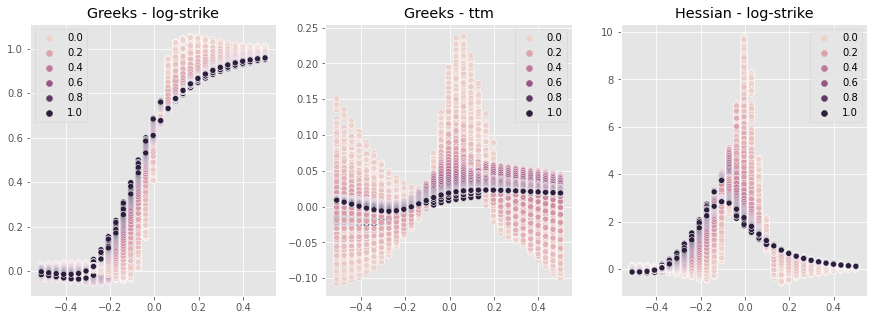

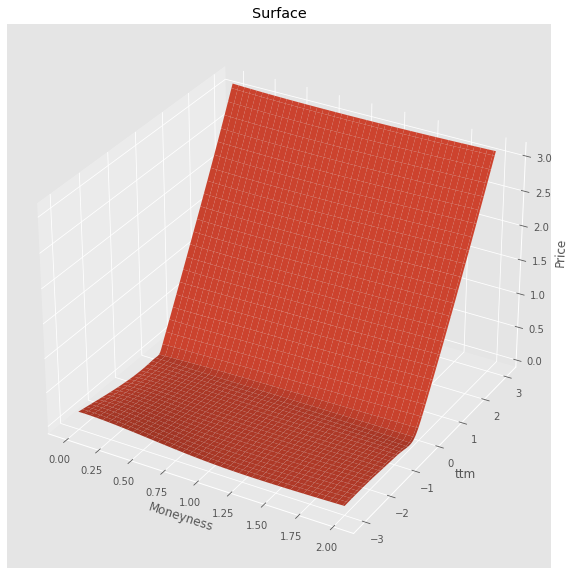

In [34]:
"""
Prediction Errors
"""
start2 = time.time()
model = all_models[METHOD]
preds = model.predict(Xs_test, batch_size=10 ** 4).reshape(-1)
X_tensor = tf.Variable(Xs_test)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log-strike")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()

temp = pd.concat(
    [
        diagnosis_pred(true, preds, lower_bound=intrinsic_val, method=METHOD),
        diagnosis_grads(
            hessian_moneyness, grads, f_to_i, "ttm", "log-strike", method=METHOD
        ),
    ],
    axis=1,
)
inference_time = time.time() - start

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, x in enumerate(["log-strike", "ttm"]):
    sns.scatterplot(
        Xs_train[:, f_to_i("log-strike")],
        grads[:, f_to_i(x)],
        hue=Xs_train[:, f_to_i("ttm")],
        ax=ax[i],
    )
    ax[i].set_title(f"Greeks - {x}")

sns.scatterplot(
    Xs_train[:, f_to_i("log-strike")],
    hessian_moneyness[:, f_to_i("log-strike")],
    ax=ax[2],
    hue=Xs_train[:, f_to_i("ttm")],
)
ax[2].set_title(f"Hessian - log-strike")

temp["model_parameters"] = all_models[METHOD].count_params()
temp["train_time"] = train_time
temp["inference_time"] = inference_time

all_res += [temp.copy()]

"""
Visualise call surface
"""
N_POINTS = 128
SK = np.linspace(-3.0, 3, N_POINTS)
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS ** 2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
sample_params = X_df.sample(1).iloc[0].to_dict()
for x in [i for i in feat_names if i not in ["ttm", "log-strike"]]:
    X[:, f_to_i(x)] = sample_params[x] * np.ones(X.shape[0])

temp = visualise_surface(ts, SK, model(X).numpy())

In [35]:
res_df = (
    pd.concat(all_res)
    .reset_index()
    .drop_duplicates(subset=["index"], keep="last")
    .set_index("index")
    .T
)
print(res_df.style.format("{:.5f}").to_latex())
res_df.style.background_gradient(axis=1)

\begin{tabular}{lrrrr}
{index} & {standard_ffn} & {gated} & {polynomial} & {differential} \\
l1 & 0.00234 & 0.01151 & 0.00465 & 0.02410 \\
l2 & 0.00340 & 0.01436 & 0.00619 & 0.03489 \\
l_inf & 0.03079 & 0.06366 & 0.04127 & 0.12490 \\
lower_bound_violation & 0.52026 & 0.38516 & 0.52664 & 0.75325 \\
monotonicity_error & 0.10706 & 0.00000 & 0.12903 & 0.19262 \\
time_value_error & 0.14131 & 0.00000 & 0.00000 & 0.32143 \\
convex_error & 0.53832 & 0.00000 & 0.33800 & 0.17792 \\
model_parameters & 4609.00000 & 576.00000 & 36.00000 & 4609.00000 \\
train_time & 102.24589 & 100.04282 & 0.21264 & 122.52462 \\
inference_time & 113.11774 & 101.81466 & 0.43244 & 123.70976 \\
\end{tabular}



index,standard_ffn,gated,polynomial,differential
l1,0.002341,0.011509,0.004654,0.024105
l2,0.003396,0.014361,0.006195,0.034886
l_inf,0.030792,0.063661,0.041274,0.124899
lower_bound_violation,0.520260,0.385161,0.526639,0.753247
monotonicity_error,0.107055,0.000000,0.129032,0.192622
time_value_error,0.141311,0.000000,0.000000,0.321426
convex_error,0.538325,0.000000,0.338002,0.177919
model_parameters,4609.000000,576.000000,36.000000,4609.000000
train_time,102.245891,100.042822,0.212638,122.524617
inference_time,113.117742,101.814663,0.432439,123.709759


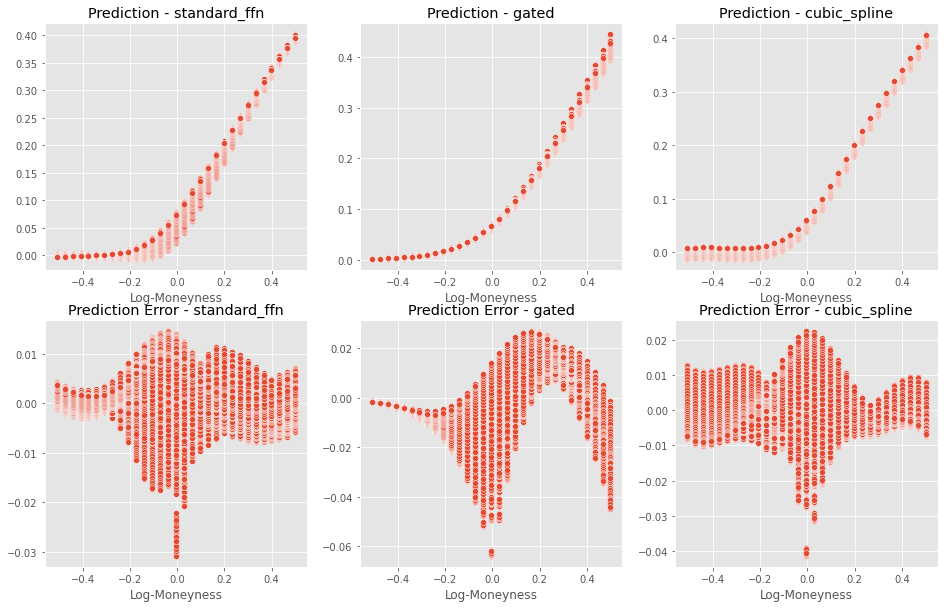

In [36]:
error_ffn = true.values - all_models["standard_ffn"].predict(Xs_test).reshape(-1)
fig, ax = plt.subplots(ncols=3, figsize=(16, 10), nrows=2)
sns.scatterplot(
    Xs_test[:, f_to_i("log-strike")],
    all_models["standard_ffn"].predict(Xs_test).reshape(-1),
    ax=ax[0, 0],
)
sns.scatterplot(Xs_test[:, f_to_i("log-strike")], error_ffn, ax=ax[1, 0])
sns.scatterplot(
    Xs_test[:, f_to_i("log-strike")],
    all_models["gated"]
    .predict([Xs_test[:, 0], Xs_test[:, 1], Xs_test[:, 2:]])
    .reshape(-1),
    ax=ax[0, 1],
)
error_gated = true.values - all_models["gated"].predict(
    [Xs_test[:, 0], Xs_test[:, 1], Xs_test[:, 2:]]
).reshape(-1)
sns.scatterplot(Xs_test[:, f_to_i("log-strike")], error_gated, ax=ax[1, 1])
error_poly = true.values - reg.predict(spline.transform(Xs_test))
sns.scatterplot(
    Xs_test[:, f_to_i("log-strike")],
    reg.predict(spline.transform(Xs_test)),
    ax=ax[0, 2],
)
sns.scatterplot(Xs_test[:, f_to_i("log-strike")], error_poly, ax=ax[1, 2])

for i, x in enumerate(["standard_ffn", "gated", "cubic_spline"]):
    ax[0, i].set_title(f"Prediction - {x}")
    ax[0, i].set_xlabel("Log-Moneyness")
    ax[1, i].set_title(f"Prediction Error - {x}")
    ax[1, i].set_xlabel("Log-Moneyness")

<AxesSubplot:>

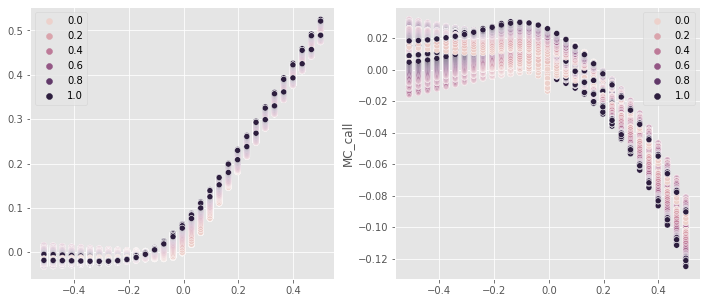

In [42]:
"""
Pricing Error
"""
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)
sns.scatterplot(
    Xs_test[:, f_to_i("log-strike")],
    true - preds,
    hue=Xs_test[:, f_to_i("ttm")],
    ax=ax[1],
)
sns.scatterplot(
    Xs_test[:, f_to_i("log-strike")], preds, hue=Xs_test[:, f_to_i("ttm")], ax=ax[0]
)

In [37]:
"""
Neural Network Hyperparameters
"""
HIDDEN_UNITS = 4096
LAYERS = 1
dropout_ratio = 0.0
HIDDEN_ACT = "swish"
N_FEATS = len(feat_names)
OUTPUT_ACT = "linear"
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 30
BATCH_NORM = False
KERNEL_INIT = "he_normal"
loss_fn = tf.keras.losses.MeanSquaredError()
METRICS = [
    tf.keras.metrics.MeanAbsoluteError(name="MAE"),
    tf.keras.metrics.RootMeanSquaredError(name="RMSE"),
]
VAL_SPLIT = 0.2

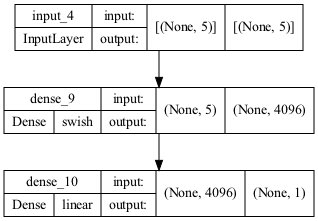

In [38]:
"""
Define Neural Network
"""
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    TQDMProgressBar(show_epoch_progress=False),
    ReduceLROnPlateau(patience=5),
]
opt = Adam(learning_rate=LR)
METHOD = "standard_ffn"

all_models[METHOD] = make_model(
    N_FEATS,
    HIDDEN_UNITS,
    LAYERS,
    DROPOUT_RATIO,
    HIDDEN_ACT,
    OUTPUT_ACT,
    BATCH_NORM,
    KERNEL_INIT,
)
all_models[METHOD].compile(optimizer=opt, loss=loss_fn, metrics=METRICS)
tf.keras.utils.plot_model(
    all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
)

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

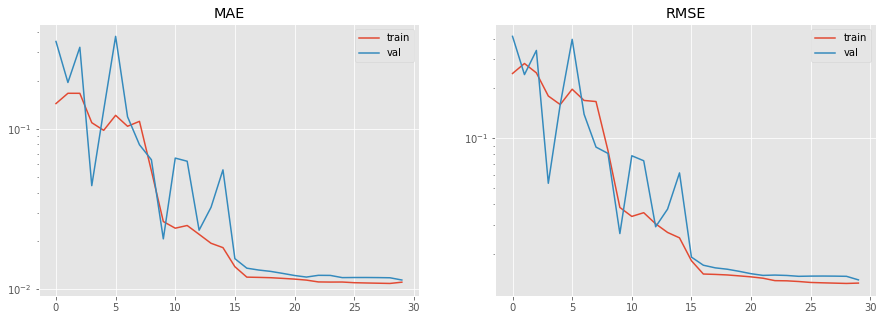

In [39]:
"""
Training
"""
start = time.time()
history = all_models[METHOD].fit(
    Xs_train,
    ys_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    shuffle=False,
    verbose=0,
    callbacks=CALLBACKS,
)
train_time = time.time() - start

metrics = ["MAE", "RMSE"]
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_yscale("log")
    ax[i].set_title(metric)

<AxesSubplot:ylabel='MC_call'>

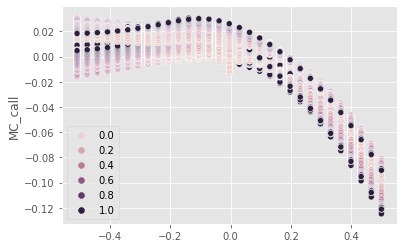

In [41]:
preds = model.predict(Xs_test, batch_size=10 ** 5).reshape(-1)
sns.scatterplot(
    Xs_test[:, f_to_i("log-strike")], true - preds, hue=Xs_test[:, f_to_i("ttm")]
)